# <center>German real estate apartment listings over time</center>


## 0) Imports

In [23]:
import concurrent.futures
import time
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob

import dataprocessing as dp

%load_ext nb_black
%matplotlib inline

plt.rcParams["figure.dpi"] = 130
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", None)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## 1) Data Engineering

### 1.1) Data processing:

#### find dates:

In [3]:
dates = sorted(
    [
        s[s.find("mieten") + len("mieten") : s.rfind(".csv")]
        for s in glob.glob("../data/mieten*")
    ]
)

<IPython.core.display.Javascript object>

#### create time series dataframe with multithreading:

In [4]:
start = time.perf_counter()
with concurrent.futures.ThreadPoolExecutor() as executor:
    combined_dfs = executor.map(dp.create_combined_df, dates)

time_df = pd.concat(combined_dfs, axis=1)
time_df = time_df.replace([np.inf, -np.inf], np.nan)
time_df = time_df.dropna()

finish = time.perf_counter()
print(f"Loaded in {round(finish-start, 2)} seconds")

Loaded in 52.24 seconds


<IPython.core.display.Javascript object>

#### add columns for change:

In [5]:
startdate = dates[0]
enddate = dates[-1]
time_df["median_yearly_ROI change"] = dp.compute_change(
    time_df, "median_yearly_ROI ", startdate, enddate
)
time_df["median_rent_m2 change"] = dp.compute_change(
    time_df, "median_rent_m2 ", startdate, enddate
)
time_df["num_rent change"] = dp.compute_change(time_df, "num_rent ", startdate, enddate)
time_df["median_price_m2 change"] = dp.compute_change(
    time_df, "median_price_m2 ", startdate, enddate
)
time_df["num_sale change"] = dp.compute_change(time_df, "num_sale ", startdate, enddate)


move_cols = [
    "median_yearly_ROI change",
    "median_rent_m2 change",
    "num_rent change",
    "median_price_m2 change",
    "num_sale change",
]
time_df = time_df[move_cols + [col for col in time_df.columns if col not in move_cols]]

<IPython.core.display.Javascript object>

## 2) Results

### 2.1) Overview

In [7]:
min_num = 5
startdate = dates[0]
enddate = dates[-1]
time_ord = "median_yearly_ROI change"

time_filt = (
    (time_df["num_rent " + startdate] > min_num)
    & (time_df["num_rent " + startdate] > min_num)
    & (time_df["num_sale " + enddate] > min_num)
    & (time_df["num_sale " + enddate] > min_num)
)

time_df[time_filt].sort_values(time_ord, ascending=False)

,median_yearly_ROI change,median_rent_m2 change,num_rent change,median_price_m2 change,num_sale change,median_yearly_ROI 2020-04-04,median_rent_m2 2020-04-04,num_rent 2020-04-04,median_price_m2 2020-04-04,num_sale 2020-04-04,...,median_yearly_ROI 2020-05-28,median_rent_m2 2020-05-28,num_rent 2020-05-28,median_price_m2 2020-05-28,num_sale 2020-05-28,median_yearly_ROI 2020-05-31,median_rent_m2 2020-05-31,num_rent 2020-05-31,median_price_m2 2020-05-31,num_sale 2020-05-31
zipCode,,,,,,,,,,,,,,,,,,,,,
47229,4.75,0.97,1.18,0.21,1.80,0.03,6.59,22.0,2811.97,5.0,...,0.13,6.40,24.0,576.92,9.0,0.13,6.42,26.0,576.92,9.0
80937,2.66,2.37,1.14,0.89,1.67,0.02,12.79,7.0,8328.18,6.0,...,0.05,30.54,7.0,7672.31,10.0,0.05,30.27,8.0,7418.80,10.0
6231,2.62,1.01,1.06,0.38,2.00,0.06,5.29,99.0,1097.56,3.0,...,0.15,5.32,101.0,421.70,6.0,0.15,5.32,105.0,421.70,6.0
17153,1.91,1.00,0.67,0.61,2.00,0.06,5.00,6.0,1027.40,3.0,...,0.11,5.00,4.0,629.37,6.0,0.11,5.00,4.0,629.37,6.0
48157,1.86,0.89,1.43,0.48,7.00,0.03,10.00,7.0,4666.67,1.0,...,0.05,9.06,10.0,2420.98,6.0,0.05,8.88,10.0,2223.53,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24837,0.45,0.97,0.92,2.14,0.95,0.05,6.73,39.0,1703.82,22.0,...,0.04,6.51,41.0,1900.00,17.0,0.02,6.50,36.0,3650.00,21.0
13357,0.42,0.46,2.00,1.09,0.93,0.07,24.40,6.0,4356.90,41.0,...,0.03,11.46,15.0,4785.25,39.0,0.03,11.27,12.0,4751.11,38.0
47475,0.39,0.79,1.26,2.07,1.67,0.08,8.10,34.0,1175.94,6.0,...,0.03,6.85,37.0,2860.87,9.0,0.03,6.40,43.0,2430.43,10.0


<IPython.core.display.Javascript object>

### 2.2) Apartments for rent

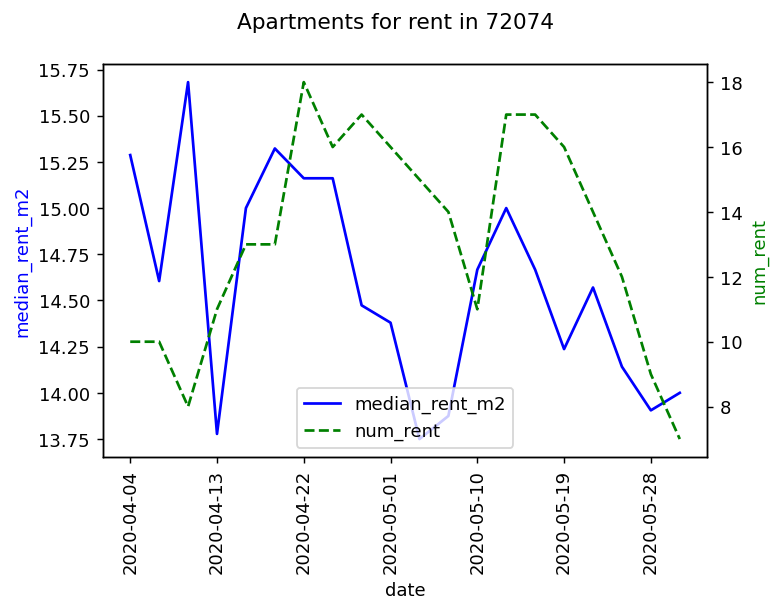

<IPython.core.display.Javascript object>

In [8]:
group_attributes = [72074]
feature1 = "median_rent_m2"
feature2 = "num_rent"

for attr in group_attributes:
    dp.plot_2features(time_df, "rent", attr, dates, feature1, feature2)

### 2.3) Apartments for sale

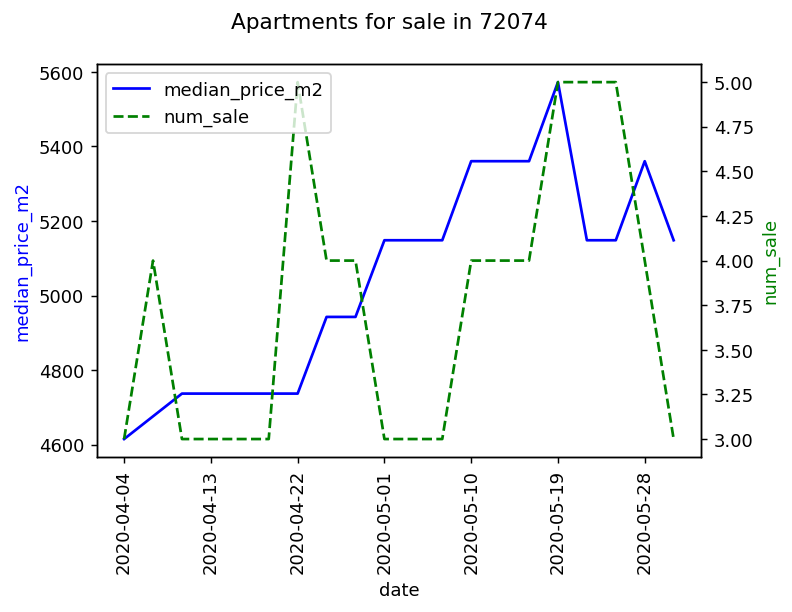

<IPython.core.display.Javascript object>

In [9]:
group_attributes = [72074]
feature1 = "median_price_m2"
feature2 = "num_sale"

for attr in group_attributes:
    dp.plot_2features(time_df, "sale", attr, dates, feature1, feature2)

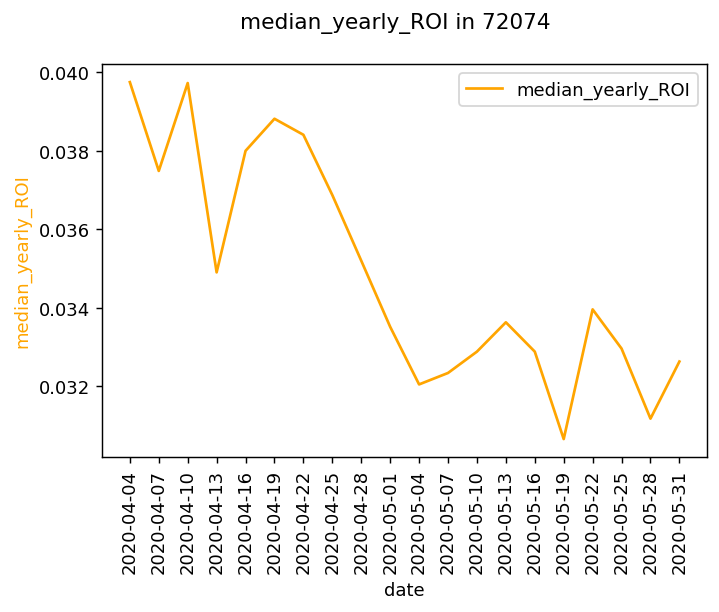

<IPython.core.display.Javascript object>

In [21]:
group_attributes = [72074]
feature1 = "median_yearly_ROI"

for attr in group_attributes:
    dp.plot_1feature(time_df, attr, dates, feature1)

## 3) Predictive Modeling

In [24]:
time_df

,median_yearly_ROI change,median_rent_m2 change,num_rent change,median_price_m2 change,num_sale change,median_yearly_ROI 2020-04-04,median_rent_m2 2020-04-04,num_rent 2020-04-04,median_price_m2 2020-04-04,num_sale 2020-04-04,median_yearly_ROI 2020-04-07,median_rent_m2 2020-04-07,num_rent 2020-04-07,median_price_m2 2020-04-07,num_sale 2020-04-07,median_yearly_ROI 2020-04-10,median_rent_m2 2020-04-10,num_rent 2020-04-10,median_price_m2 2020-04-10,num_sale 2020-04-10,median_yearly_ROI 2020-04-13,median_rent_m2 2020-04-13,num_rent 2020-04-13,median_price_m2 2020-04-13,num_sale 2020-04-13,median_yearly_ROI 2020-04-16,median_rent_m2 2020-04-16,num_rent 2020-04-16,median_price_m2 2020-04-16,num_sale 2020-04-16,median_yearly_ROI 2020-04-19,median_rent_m2 2020-04-19,num_rent 2020-04-19,median_price_m2 2020-04-19,num_sale 2020-04-19,median_yearly_ROI 2020-04-22,median_rent_m2 2020-04-22,num_rent 2020-04-22,median_price_m2 2020-04-22,num_sale 2020-04-22,median_yearly_ROI 2020-04-25,median_rent_m2 2020-04-25,num_rent 2020-04-25,median_price_m2 2020-04-25,num_sale 2020-04-25,median_yearly_ROI 2020-04-28,median_rent_m2 2020-04-28,num_rent 2020-04-28,median_price_m2 2020-04-28,num_sale 2020-04-28,median_yearly_ROI 2020-05-01,median_rent_m2 2020-05-01,num_rent 2020-05-01,median_price_m2 2020-05-01,num_sale 2020-05-01,median_yearly_ROI 2020-05-04,median_rent_m2 2020-05-04,num_rent 2020-05-04,median_price_m2 2020-05-04,num_sale 2020-05-04,median_yearly_ROI 2020-05-07,median_rent_m2 2020-05-07,num_rent 2020-05-07,median_price_m2 2020-05-07,num_sale 2020-05-07,median_yearly_ROI 2020-05-10,median_rent_m2 2020-05-10,num_rent 2020-05-10,median_price_m2 2020-05-10,num_sale 2020-05-10,median_yearly_ROI 2020-05-13,median_rent_m2 2020-05-13,num_rent 2020-05-13,median_price_m2 2020-05-13,num_sale 2020-05-13,median_yearly_ROI 2020-05-16,median_rent_m2 2020-05-16,num_rent 2020-05-16,median_price_m2 2020-05-16,num_sale 2020-05-16,median_yearly_ROI 2020-05-19,median_rent_m2 2020-05-19,num_rent 2020-05-19,median_price_m2 2020-05-19,num_sale 2020-05-19,median_yearly_ROI 2020-05-22,median_rent_m2 2020-05-22,num_rent 2020-05-22,median_price_m2 2020-05-22,num_sale 2020-05-22,median_yearly_ROI 2020-05-25,median_rent_m2 2020-05-25,num_rent 2020-05-25,median_price_m2 2020-05-25,num_sale 2020-05-25,median_yearly_ROI 2020-05-28,median_rent_m2 2020-05-28,num_rent 2020-05-28,median_price_m2 2020-05-28,num_sale 2020-05-28,median_yearly_ROI 2020-05-31,median_rent_m2 2020-05-31,num_rent 2020-05-31,median_price_m2 2020-05-31,num_sale 2020-05-31
zipCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1067,0.99,0.96,0.93,0.97,0.33,0.06,11.50,273.0,2135.34,3.0,0.06,11.00,290.0,2135.34,3.0,0.06,11.50,261.0,2135.34,3.0,0.06,11.21,285.0,2135.34,3.0,0.06,11.01,288.0,2135.34,3.0,0.06,11.50,275.0,2135.34,3.0,0.06,11.21,273.0,2108.02,4.0,0.06,11.02,286.0,2135.34,5.0,0.06,11.05,279.0,2135.34,5.0,0.06,10.91,282.0,2135.34,5.0,0.06,10.50,295.0,2108.02,4.0,0.06,10.83,285.0,2080.69,3.0,0.06,10.88,278.0,2080.69,3.0,0.06,10.50,276.0,2108.02,2.0,0.06,10.63,274.0,2108.02,2.0,0.06,10.96,264.0,2108.02,2.0,0.06,10.71,293.0,2108.02,2.0,0.06,10.77,277.0,2108.02,2.0,0.06,10.84,286.0,2108.02,2.0,0.06,11.04,254.0,2080.69,1.0
1069,1.14,1.05,0.88,0.92,0.79,0.03,8.63,90.0,3970.12,14.0,0.03,8.63,75.0,4110.18,18.0,0.03,8.67,84.0,3970.12,14.0,0.03,8.99,86.0,3970.12,14.0,0.03,8.63,83.0,3970.12,14.0,0.03,8.98,89.0,3970.24,11.0,0.03,9.00,99.0,3970.12,14.0,0.03,8.99,96.0,3970.12,14.0,0.03,9.00,95.0,3970.12,14.0,0.03,8.98,103.0,3970.12,14.0,0.03,8.84,100.0,3970.21,16.0,0.03,8.91,97.0,3585.62,8.0,0.03,8.91,99.0,4192.86,18.0,0.03,9.25,82.0,3887.87,14.0,0.03,9.15,94.0,3547.39,7.0,0.03,9.00,101.0,3547.39,7.0,0.03,9.04,93.0,3640.02,13.0,0.03,9.05,92.0,3623.85,11.0,0.03,8.30,113.0,3640.02,11.0,0.03,9.04,79.0,3640.02,11.0
1097,0.83,1.06,1.20,1.28,1.31,0.05,9.50,113.0,2100.00,13.0,0.05,9.43,114.0,2100.00,13.0,0.05,9.50,112.0,2169.40,14.0,0.05,9.39,122.0,2100.00,13

<IPython.core.display.Javascript object>